In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 하이퍼 파라미터 지정
batch_size = 256
learning_rate = 0.01  # 학습률 조정
num_epoch = 10

In [4]:
# 데이터 다운로드
mnist_train = dset.MNIST(root="../", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST(root="../", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 125048383.03it/s]

Extracting ../MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 122980399.82it/s]


Extracting ../MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34312165.22it/s]

Extracting ../MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3621085.11it/s]


Extracting ../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST/raw



In [5]:
# 데이터셋 체크
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

print(len(mnist_train), len(mnist_test))

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000


In [6]:
# DataLoader 설정
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [8]:
# CNN 모델 구현
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),  # kernel size 변경
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),  # kernel size 변경
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(32 * 5 * 5, 256),  # 64*3*3 -> 32*5*5, 100 -> 256
            nn.Dropout(0.8),  # 드롭아웃 적용
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

In [9]:
# 손실 함수, 최적화 함수

# gpu가 사용 가능한 경우에는 device를 gpu로 설정하고 불가능하면 cpu로 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 모델을 지정한 장치로 올리기
model = CNN().to(device)

# 손실함수로는 크로스엔트로피
loss_func = nn.CrossEntropyLoss()

# 최적화 함수로는 Adam 대신 SGD를 사용
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # Adam -> SGD로 변경

loss_arr = []
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

cuda:0
tensor(2.3174, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1204, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1746, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7327, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7441, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5673, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4850, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4281, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4601, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3152, device='cuda:0', grad_fn=<NllLossBackward0>)


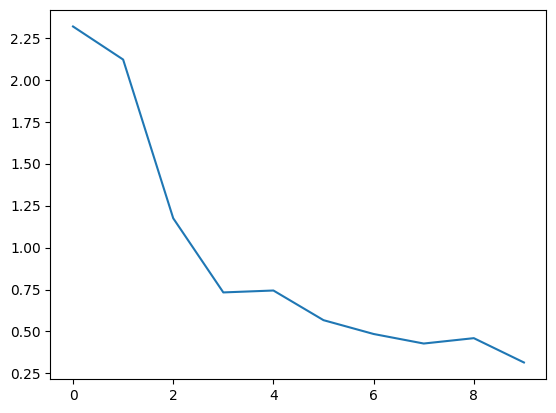

In [10]:
plt.plot(loss_arr)
plt.show()

In [11]:
# 테스트 데이터 정확도 측정
# 맞은 개수, 전체 개수를 저장할 변수 지정
correct = 0
total = 0

# 인퍼런스 모드를 위해 no_grad
with torch.no_grad():
    # 테스트 로더에서 이미지와 정답을 불러오기
    for image, label in test_loader:
        # 두 데이터 모두 장치에 올리기
        x = image.to(device)
        y_ = label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)

        # torch.max를 이용해 최대 값 및 최대값 인덱스를 뽑아냅니다.
        # 여기서는 최대값은 필요없기 때문에 인덱스만 사용합니다.
        _, output_index = torch.max(output, 1)

        # 전체 개수는 라벨의 개수로 더해줍니다.
        # 전체 개수를 알고 있음에도 이렇게 하는 이유는 batch_size, drop_last의 영향으로 몇몇 데이터가 잘릴수도 있기 때문입니다.
        total += label.size(0)

        # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 correct에 더해줍니다.
        correct += (output_index == y_).sum().float()

# 테스트 데이터 전체에 대해 위의 작업을 시행한 후 정확도를 구해줍니다.
print("Accuracy of Test Data: {}%".format(100 * correct / total))

Accuracy of Test Data: 89.32291412353516%
